# GET POSSIBLE FISH FROM SEGMENTED WELL

In [242]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import skimage
import cv2 as cv

from skimage import filters, measure, io, segmentation, morphology

from src.well.find_well_props import find_well_props

## Find well props

In [243]:
from src.InputImage import InputImage

fishy = InputImage('zf2.jpg')

fishy = find_well_props(fishy)

# Find well props
_____________________________________________________________
# Hough-transformation for the well
_____________________________________________________________
# Create circle mask for image
_____________________________________________________________
# Creating mask
_____________________________________________________________
# Get bounding box
_____________________________________________________________


x1: 0,
y1: 0,
x2: 1040,
y2: 1186


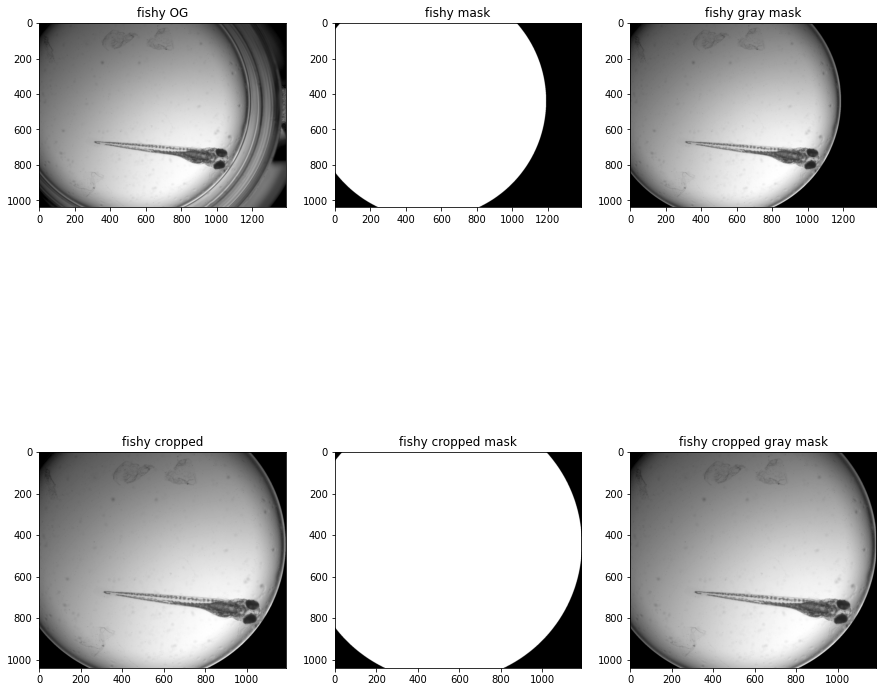

In [244]:
from src.InputImage import InputImage

fishy = InputImage('zf2.jpg')

fishy = find_well_props(fishy)

## HPF
couldn't seem to find a good homomoprhic filter

is used an implementation of a high pass filter from 'https://www.geeksforgeeks.org/implement-photoshop-high-pass-filter-hpf-using-opencv-in-python/'

then equalized the resulting image

In [245]:
from skimage.morphology import dilation, erosion, square
from skimage.exposure import equalize_hist

[[1 1 1]
 [1 1 1]
 [1 1 1]]


(array([109382.,   3581.,   3744.,   4032.,   4804.,   3585.,   4821.,
             0.,   6369.,      0.,   8765.,      0.,      0.,  14672.,
             0.,      0.,      0.,      0.,      0.,      0.,  33863.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,  94105.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0., 208986.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

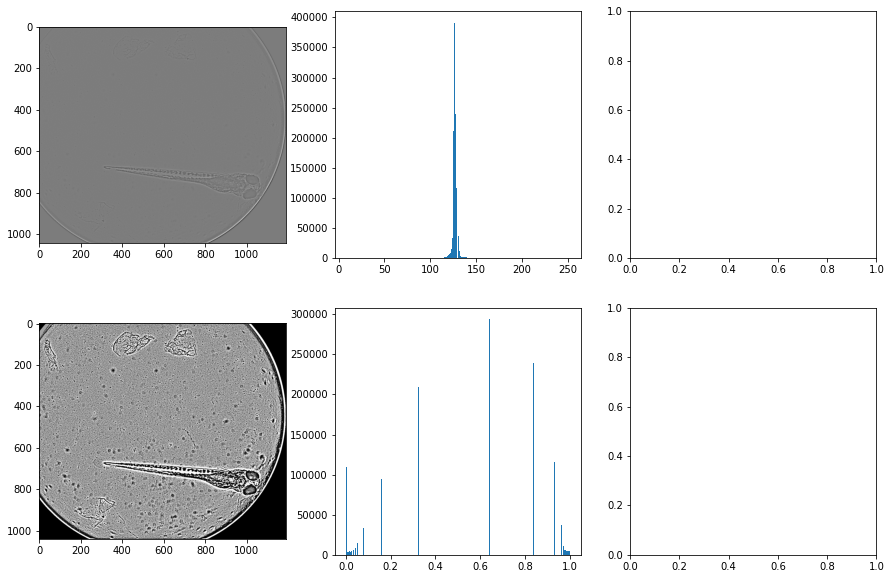

In [246]:
specless = fishy.well_props.mask.cropped_gray
hpf = specless - cv.GaussianBlur(specless, (21, 21), 3) + 127
equalized = equalize_hist(hpf)

equalized = np.multiply(equalized, fishy.well_props.mask.cropped)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

se = square(3)
print(se)

ax[0, 0].imshow(hpf, 'gray')
ax[0, 1].hist(hpf.ravel(), bins=256)

ax[1, 0].imshow(equalized, 'gray')
ax[1, 1].hist(equalized.ravel(), bins=256)


[[1 1 1]
 [1 1 1]
 [1 1 1]]


(array([109382.,   3581.,   3744.,   4032.,   4804.,   3585.,   4821.,
             0.,   6369.,      0.,   8765.,      0.,      0.,  14672.,
             0.,      0.,      0.,      0.,      0.,      0.,  33863.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,  94105.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0., 208986.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

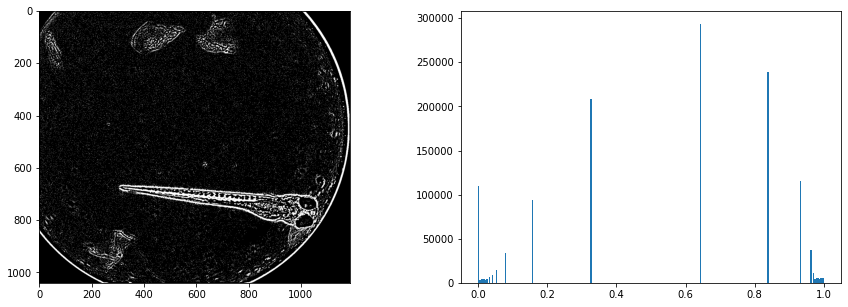

In [247]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

threshed = (equalized > 0.94).astype(int)
print(se)
ax[0].imshow(threshed, 'gray')
ax[1].hist(equalized.ravel(), bins=256)

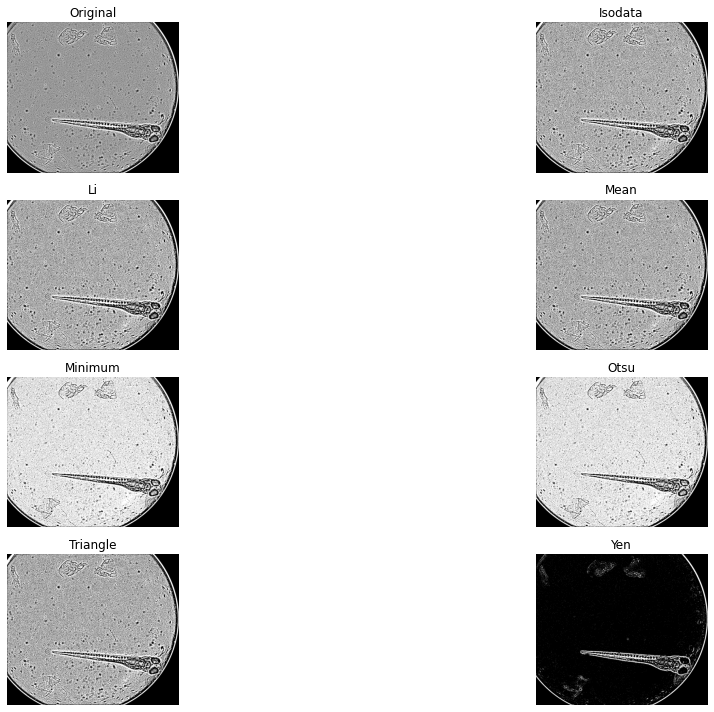

In [248]:
fig, ax = filters.try_all_threshold(equalized, figsize=(20, 10), verbose=False)
plt.show()

## Get the binary thresholded image

Yen thresholding

Text(0.5, 1.0, 'tewstie')

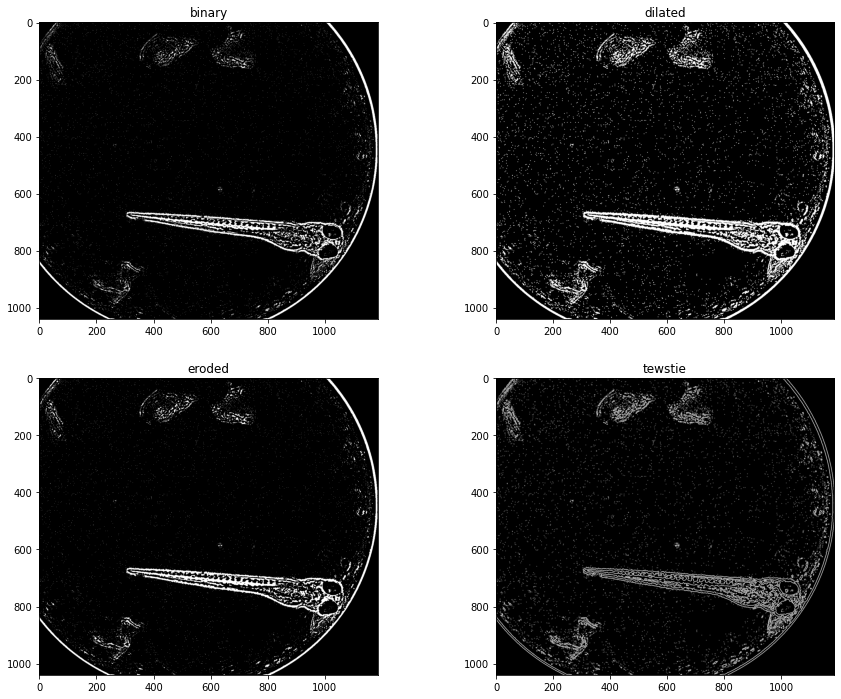

In [338]:
from skimage.filters.edges import sobel
from skimage.morphology import disk
from skimage.filters.thresholding import threshold_local, threshold_yen

thresh = threshold_yen(equalized)
binary = equalized > thresh
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

dilated = morphology.binary_dilation(binary)
eroded = morphology.binary_erosion(dilated)

# closed = morphology.binary_closing(binary)
size = fishy.well_props.mask.cropped_gray.size * 0.1
closed = morphology.area_closing(binary, size)

"""testie = morphology.remove_small_objects(dilated)
"""
ax[0, 0].imshow(binary, 'gray')
ax[0, 0].set_title('binary')
ax[0, 1].imshow(dilated, 'gray')
ax[0, 1].set_title('dilated')
ax[1, 0].imshow(eroded, 'gray')
ax[1, 0].set_title('eroded')
ax[1, 1].imshow(sobel(eroded), 'gray')
ax[1, 1].set_title('tewstie')


## Removing specless

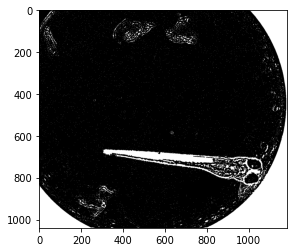

In [360]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology, skimage.data

testie = morphology.remove_small_holes(eroded, size)

specless = testie
size_th = specless.size * 0.001

# specless = morphology.remove_small_objects(testie, size_th)
"""
labels = skimage.morphology.label(specless)
labelCount = np.bincount(labels.ravel())
background = np.argmax(labelCount)
specless[labels != background] = 255
"""
plt.imshow(specless, 'gray')
plt.show()

In [370]:
def get_plate_width_and_remove_sides(binary: np.ndarray, mask: np.ndarray, corrected=False):
    binary_img = binary
    well_mask = mask

    if binary_img.shape != well_mask.shape:
        raise Exception("Arguments 'binary_img' and 'well_mask' must have equal shape" +
                        f"\n'binary_img': {binary_img.shape} != 'well_mask': {well_mask.shape}")

    possible_well_size_th = np.zeros_like(binary_img)
    remaining_binary_img = binary_img

    if not corrected:
        structuring_element = disk(21)
        eroded_well = erosion(well_mask, structuring_element)
        remaining_binary_img[np.where(eroded_well > 0)] = 0
    #    remaining_binary_img = morphology.area_opening(remaining_binary_img, 100)

    mh, mw = binary_img.shape
    h_center, w_center = int(mh / 2), int(mw / 2)

    lt = remaining_binary_img[0:h_center, 0:w_center]
    lb = remaining_binary_img[h_center:mh, 0:w_center]
    rt = remaining_binary_img[0:h_center, w_center:mw]
    rb = remaining_binary_img[h_center:mh, w_center:mw]

    lt_thresh = get_mean_col_sum_for_structuring_element(lt, "lt", corrected)
    lb_thresh = get_mean_col_sum_for_structuring_element(lb, "lb", corrected)
    rt_thresh = get_mean_col_sum_for_structuring_element(rt, "rt", corrected)
    rb_thresh = get_mean_col_sum_for_structuring_element(rb, "rb", corrected)

    return [lt, rt, lb, rb]

C:\Users\gimesia\.virtualenvs\zebrafish_pipenv-QxNREiAZ\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\gimesia\.virtualenvs\zebrafish_pipenv-QxNREiAZ\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, '')

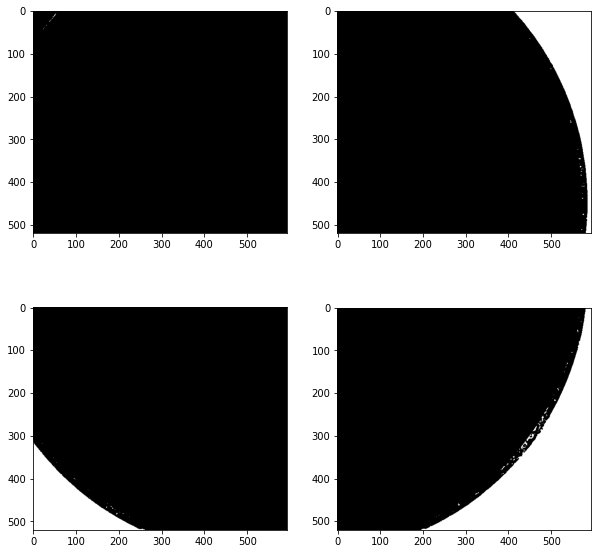

In [371]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

binarey = specless
mask = fishy.well_props.mask.cropped

a, b, c, d = get_plate_width_and_remove_sides(binarey, mask)

ax[0, 0].imshow(a, 'gray')
ax[0, 0].set_title('')
ax[0, 1].imshow(b, 'gray')
ax[0, 1].set_title('')
ax[1, 0].imshow(c, 'gray')
ax[1, 0].set_title('')
ax[1, 1].imshow(d, 'gray')
ax[1, 1].set_title('')

In [252]:
def get_mean_col_sum_for_structuring_element(data: np.ndarray, corner: str, corrected_step: bool):  #cont, mod_cont
    thresh_well = np.zeros_like(data.shape)

    col_sum = np.sum(data[-1:1])  # in matlab ->   data'
    mean_data = np.floor(np.mean(col_sum[(col_sum > 0)]))
    """
        if not corrected_step:
            img = cont
        else:
            img = mod_cont
    """
    if not np.isnan(mean_data):
        structuring_element = disk(mean_data)
        if corner == 'lt':
            thresh_well = dilation(
                specless[0:np.floor(specless.shape[0] / 2), 0:np.floor(specless.shape[1] / 2)],
                structuring_element)
        elif corner == 'lb':
            thresh_well = dilation(
                specless[np.floor(specless.shape[0] / 2):specless.shape[0], 0:np.floor(specless.shape[1] / 2)],
                structuring_element)
        elif corner == 'rt':
            thresh_well = dilation(
                specless[0:np.floor(specless.shape[0] / 2), np.floor(specless.shape[1] / 2):specless.shape[1]],
                structuring_element)
        elif corner == 'rb':
            thresh_well = dilation(
                specless[np.floor(specless.shape[0] / 2):specless.shape[0],
                np.floor(specless.shape[1] / 2):specless.shape[1]],
                structuring_element)

    return thresh_well

## Gamma illumination adjustment
Trying to replace homomorphic filter

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

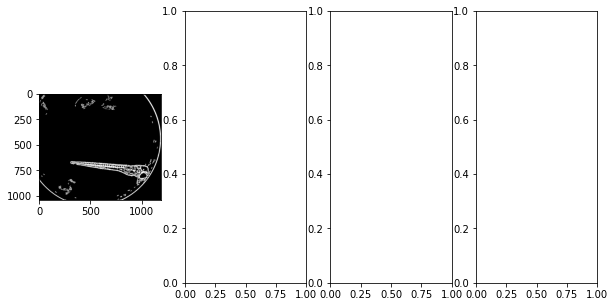

In [253]:
from skimage.exposure import adjust_gamma, adjust_log

data = testie

gamma_low_val = 0.05
gamma_low = adjust_gamma(data, gamma_low_val)

gamma_high_val = 1.2
gamma_high = adjust_gamma(data, gamma=gamma_high_val)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))

ax[0].imshow(gamma_high, 'gray')
ax[1].hist(gamma_high.ravel(), bins=256)
ax[2].imshow(gamma_low, 'gray')
ax[2].set_title('gamma_low')

ax[3].hist(gamma_low.ravel(), bins=256)
ax[3].set_title('gamma_low')

## Gamma illumination adjustment
Trying to replace homomorphic filter

Text(0.5, 1.0, 'gamma_low')

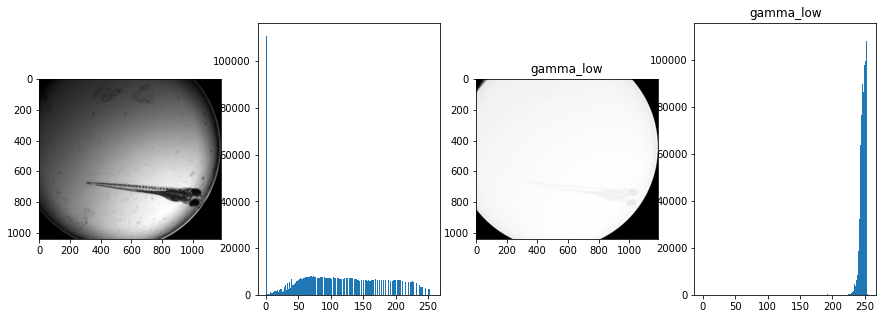

In [121]:
from skimage.exposure import adjust_gamma, adjust_log

data = fishy.processed

gamma_low_val = 0.05
gamma_low = adjust_gamma(data, gamma_low_val)

gamma_high_val = 1.8
gamma_high = adjust_gamma(data, gamma=gamma_high_val)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

ax[0].imshow(gamma_high, 'gray')
ax[1].hist(gamma_high.ravel(), bins= 256)
ax[2].imshow(gamma_low, 'gray')
ax[2].set_title('gamma_low')

ax[3].hist(gamma_low.ravel(), bins= 256)
ax[3].set_title('gamma_low')